# Entry 25 notebook - Setting thresholds - PR and ROC - Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.datasets import load_digits, fetch_openml

In [2]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.grid()
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls, thresholds):
    close_default = np.argmin(np.abs(thresholds - 0.5))
    plt.plot(precisions[close_default], recalls[close_default], 'o', markersize=10,
            label='threshold zero', fillstyle="none", c='k', mew=2)
    plt.plot(recalls, precisions, "b-", linewidth=2, label='precision recall curve')
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.legend(loc='best')
    plt.grid(True)
    
def plt_roc_curve(fpr, tpr, thresholds, label='ROC curve'):
    close_default = np.argmin(np.abs(thresholds - 0.5))
    plt.plot(fpr[close_default], tpr[close_default], 'o', markersize=10,
            label='default threshold 0.5', fillstyle="none", c='k', mew=2)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Make dataset and fit model

In [3]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
df_raw = titanic.data
target = titanic.target

In [4]:
df_raw.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
features = ['pclass', 'sex', 'sibsp', 'parch']
X = df_raw.loc[:, features]
X['sex'] = X['sex'].astype('category').cat.codes
y = target.copy().astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)
pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7824427480916031

In [6]:
cross_validate(LogisticRegression(), X_train, y_train, cv=10, scoring=['precision', 'average_precision', 'recall',
                                                       'f1', 'neg_log_loss', 'neg_brier_score'])

{'fit_time': array([0.00618124, 0.00494909, 0.00464296, 0.00399375, 0.00393176,
        0.00389695, 0.003968  , 0.00396705, 0.00378084, 0.00383592]),
 'score_time': array([0.00806785, 0.00606108, 0.00616813, 0.00542998, 0.00534344,
        0.0053401 , 0.00560212, 0.00539708, 0.00542688, 0.00524998]),
 'test_precision': array([0.8125    , 0.87179487, 0.8       , 0.68571429, 0.75609756,
        0.76923077, 0.8       , 0.60526316, 0.71875   , 0.72727273]),
 'test_average_precision': array([0.79230071, 0.90616753, 0.70881106, 0.79966404, 0.82336772,
        0.81621793, 0.8053233 , 0.69845842, 0.74554448, 0.71403329]),
 'test_recall': array([0.65      , 0.85      , 0.6       , 0.6       , 0.775     ,
        0.75      , 0.7       , 0.58974359, 0.58974359, 0.61538462]),
 'test_f1': array([0.72222222, 0.86075949, 0.68571429, 0.64      , 0.7654321 ,
        0.75949367, 0.74666667, 0.5974026 , 0.64788732, 0.66666667]),
 'test_neg_log_loss': array([-0.46846179, -0.34750687, -0.56200828, -0.46758

### Precision vs Recall

In [7]:
y_scores = cross_val_predict(pipe, X_train, y_train, cv=10, method='predict_proba')[:,1]

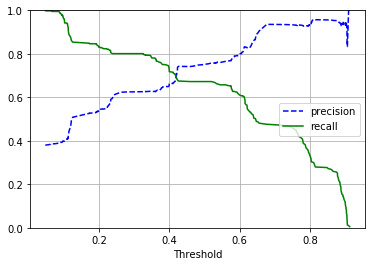

In [8]:
precisions, recalls, pr_thresholds = precision_recall_curve(y_train, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds)

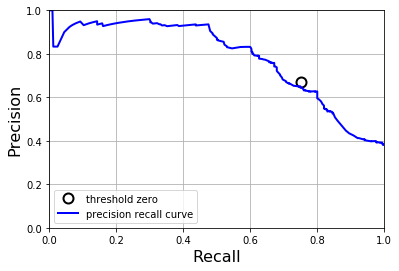

In [9]:
plot_precision_vs_recall(precisions, recalls, pr_thresholds)

In [10]:
auc(recalls, precisions)

0.7822274422984722

In [11]:
average_precision_score(y_train, y_scores)

0.7818285559523122

### ROC Curve and ROC AUC

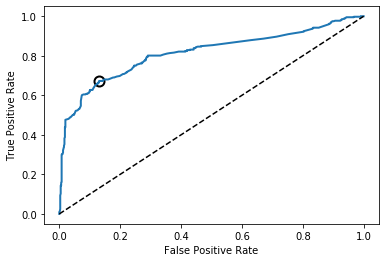

In [12]:
fpr, tpr, roc_thresholds = roc_curve(y_train, y_scores)
plt_roc_curve(fpr, tpr, roc_thresholds)

In [13]:
roc_auc_score(y_train, y_scores)

0.8138539042821158